In [6]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision 

import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available()

True

In [8]:
DATA_DIR = 'tests/00_test_img_input/train/images'

INPUT_SIZE = 170 # mean 284, median 170
BATCH_SIZE = 64
my_tranform = None

# Dataset & DataLoader

In [9]:
def preprocess(img_path, label, inference = False):
    image = Image.open(img_path).convert('RGB')
    image = np.array(image).astype(np.float32)

    # resize
    if not inference:
        target = np.copy(label)
        target[::2] = label[::2] / image.shape[0] * INPUT_SIZE
        target[1::2] = label[1::2] / image.shape[1] * INPUT_SIZE

    x = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))
    
    # normalize
    for c in range(3):
        x[:, :, c] -= np.mean(x[:, :, c])
        x[:, :, c] /= np.std(x[:, :, c]) 

    x = torch.from_numpy(x.transpose(2, 0, 1))
    
    if not inference:
        return x, target
    else:
        return x, image.shape

In [10]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

In [11]:
class MyCustomDataset(Dataset):
    def __init__(self, 
                 mode, 
                 fraction: float = 0.8, 
                 transform = None,
                 store_in_ram = True,
                 data_dir = None,
                 train_gt = None,
                 inference = False
                ):
        
        self._items = [] 
        self._transform = transform 
        self.store_in_ram = store_in_ram
        self.inference = inference
        
        # train val split
        images_dir = os.listdir(data_dir)
        if not inference:
            np.random.seed(1)
            np.random.shuffle(images_dir)
        
        labels = train_gt
        
        partition = int(fraction * len(images_dir))
        if mode == 'train':
            img_names = images_dir[:partition]
        elif mode == 'val':
            img_names = images_dir[partition:]
                
        for img_name in img_names:
            if not inference:
                label = np.array(labels[img_name]).astype(np.float32)
            else:
                label = 0
            
            img_path = os.path.join(data_dir, img_name)
            
            if self.store_in_ram:
                ## Faster on training, but takes time to preprocess and put into RAM all dataset
                x, target = preprocess(img_path, label, inference = inference)
            else:
                ## Slower on training.
                x = img_path
                target = label
            self._items.append((
                x,
                target
            ))
        
    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        if self.store_in_ram:
            return self._items.__getitem__(index)
        else:
            return preprocess(*self._items.__getitem__(index), inference = self.inference)

In [12]:
train_gt = read_csv('tests\\00_test_img_input\\train\\gt.csv')

In [8]:
## Init train and val datasets
my_transform = None

ds_train = MyCustomDataset(mode = "train", data_dir = DATA_DIR, train_gt = train_gt, transform = my_transform)
ds_val = MyCustomDataset(mode = "val", data_dir = DATA_DIR, train_gt = train_gt, transform = my_transform)

## Init train and val dataloaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Base model setup

In [13]:
class BaseModel(pl.LightningModule):
    # REQUIRED
    def __init__(self, learning_rate):
        super().__init__()
        """ Define computations here. """
        self.lr = learning_rate
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 'same') # 62 # 126 # 168 # w/ pad: 170
        self.pool1 = nn.MaxPool2d(2, 2) # 31 # 63 # 84 # w/pad: 85
        self.norm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, padding = 'same') # 29 # 61 # 82 # w/ pad: 85
        self.pool2 = nn.MaxPool2d(2, 2) # 14 # 30 # 41 # w/pad: 42
        self.norm2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 'same') # 12 # 28 # 39 # w/ pad: 42
        self.pool3 = nn.MaxPool2d(2, 2) # 6 # 14 # 19 # w/pad: 21
        self.norm3 = nn.BatchNorm2d(256)
        
#         self.global_avg_pool = nn.AvgPool2d(21)
        
        self.fc1 = nn.Linear(256 * (21)**2, 64)
        
        self.fc2 = nn.Linear(64, 28)
        

        self.loss = nn.MSELoss()
        
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        
        x = self.norm1(self.pool1(F.relu(self.conv1(x))))
#         x = F.dropout2d(x, self.p, self.training)
        x = self.norm2(self.pool2(F.relu(self.conv2(x))))
#         x = F.dropout2d(x, self.p, self.training)
        x = self.norm3(self.pool3(F.relu(self.conv3(x))))
#         x = F.dropout2d(x, self.p, self.training)
        
#         x = self.global_avg_pool(x)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2, self.training)
        
        x = self.fc2(x) 
        
        return x
    
    # REQUIRED
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        self.training = True
        
        x, y = batch

        y_pred = self(x)
        loss = self.loss(y_pred, y)
        
        eps = 5
        acc = torch.sum(torch.abs(y_pred.detach() - y) < eps) / y.shape[0] / y.shape[1]
        
        system_loss = torch.mean(((y_pred.detach() - y) / INPUT_SIZE * 100)**2)
        
        return {'loss': loss, 'acc': acc, 'train_sys' : system_loss}
    
    # REQUIRED
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay = 5e-4)
#         optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                  mode='min', 
                                                                  factor=0.5, 
                                                                  patience=10, 
                                                                  verbose=True)
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss"
        } 
        
        return [optimizer], [lr_dict]
    
    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        self.training = False
        x, y = batch
        y_pred = self(x)

        loss = self.loss(y_pred, y)
    
        eps = 5
        acc = torch.sum(torch.abs(y_pred - y) < eps) / y.shape[0] / y.shape[1]
        
        system_loss = torch.mean(((y_pred - y) / INPUT_SIZE * 100)**2)
        
        return {'val_loss': loss, 'val_acc': acc, 'val_sys' : system_loss}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        avg_sys = torch.stack([x['train_sys'] for x in outputs]).mean()
        
        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}, Train_sys: {avg_sys:.2f}" )
        
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        avg_sys = torch.stack([x['val_sys'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}, Val_sys: {avg_sys:.2f}", end= " ")
        
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)


# Callbacks setup

In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Save the model periodically by monitoring a quantity.
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_loss', 
                                    mode='min', 
                                    save_top_k=1)

## Monitor a metric and stop training when it stops improving.
MyEarlyStopping = EarlyStopping(monitor = "val_loss",
                                mode = "min",
                                patience = 20,
                                verbose = True)

c:\program files\python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:446: UserWarning: Checkpoint directory runs/pl_classifier exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


# Training

In [ ]:
LEARNING_RATE = 1e-3
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=5 # dataset is quite small
)

model = BaseModel(learning_rate = LEARNING_RATE)

trainer.fit(model, dl_train, dl_val)

# Load and evaluate

In [28]:
model_filename = 'runs/pl_classifier/epoch=61-val_loss=38.787.ckpt'
test_img_dir = 'tests/00_test_img_input/test/images'
model = BaseModel.load_from_checkpoint(model_filename, learning_rate = 1e-3)
model.eval()
model.training = False
model.to(device)

ds_test = MyCustomDataset(mode = "val", data_dir = test_img_dir, train_gt = [],
                          store_in_ram = False, inference = True)

## Init train and val dataloaders
dl_test = DataLoader(ds_test, batch_size=1, shuffle=True, num_workers=0)

ans = []

for i, (inputs, targets) in enumerate(dl_test):
    # evaluate the model on the test set
    inputs = inputs.to(device)
    res = model(inputs).detach()
    ans.append(res)
    
ans = torch.cat(ans, dim = 0).flatten().cpu().numpy().astype(np.int32)

# Augmentations

In [207]:
import albumentations as A
import matplotlib.pyplot as plt

def show_images(images, keypoints, titles = [], annotate = False) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(15,15))
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.scatter(*zip(*keypoints[i]), c = 'red')
        if annotate:
            for i, key in enumerate(keypoints[i]):
                plt.annotate(i, key, c = 'white')
        if titles != []:
            plt.xlabel(titles[i])

    plt.show(block=True)

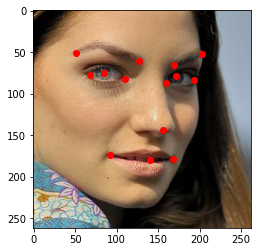

In [388]:
img_name = '00000.jpg'
image = cv2.imread("./tests/00_test_img_input/train/images/" + img_name)
points = train_gt[img_name]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.scatter(x = points[::2], y = points[1::2], c = 'red')

In [395]:
TestTransform = A.Compose(
    [A.Rotate(limit=45, p = 1),
    A.OneOf([
        A.RGBShift(r_shift_limit=0, g_shift_limit=[0,100], b_shift_limit=[0,100], p = 0.1),
        A.ToGray(p = 0.3)
    ]),
     A.GaussNoise(p = 0.3),
     A.MotionBlur(p = 0.3)
    ],
    keypoint_params = A.KeypointParams(format='xy')
)

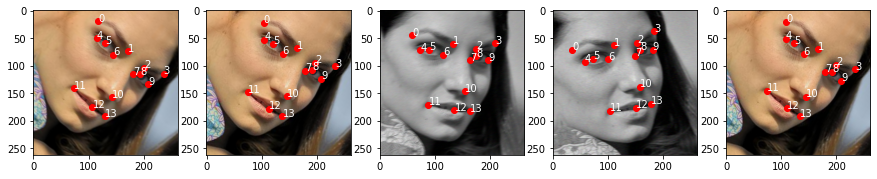

In [396]:
transformed_images = []
transformed_keypoints = []
for i in range(5):
    keypoints = np.zeros((len(points) // 2, 2))
    keypoints[:, 0] = points[::2]
    keypoints[:, 1] = points[1::2]
    transformed = TestTransform(image = image, keypoints = keypoints)
    transformed_images.append(transformed['image'])
    transformed_keypoints.append(transformed['keypoints'])
show_images(transformed_images, transformed_keypoints, annotate = True)

In [355]:
np.mean(transformed_images[-1][:,:,1])

104.61655267401237

In [345]:
np.array(transformed_keypoints[0], dtype=np.int32).ravel()

array([912, 206, 952, 477, 998, 675, 964, 966, 800, 275, 834, 382, 817,
       477, 840, 710, 857, 822, 849, 908, 515, 606, 382, 408, 362, 592,
       405, 830])

In [346]:
transformed_keypoints[0]

[(912.0, 206.0),
 (952.0, 477.0),
 (998.0, 675.0),
 (964.0, 966.0),
 (800.0, 275.0),
 (834.0, 382.0),
 (817.0, 477.0),
 (840.0, 710.0),
 (857.0, 822.0),
 (849.0, 908.0),
 (515.0, 606.0),
 (382.0, 408.0),
 (362.0, 592.0),
 (405.0, 830.0)]